# Imports

In [10]:
import math
import numpy as np
from matplotlib import pyplot as plt
from numpy import random as rnd
import warnings,datetime,os,calendar,csv,time
from tqdm import tqdm

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F 

import pandas as pd
import seaborn as sns

import gym
from bs4 import BeautifulSoup

from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')
sns.set()

# Load and preprocess data

In [2]:
rootpath = '..\\..\\TF_data\\STOCKDATA\\Data\\Stocks\\'
available_indices = os.listdir(rootpath)

In [259]:
bf = pd.read_csv(rootpath+available_indices[0]).set_index(['Date'])

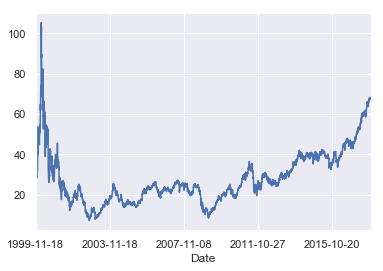

In [260]:
bf['Open'].plot()
plt.show()

In [289]:
LOOKBACK = 15
LOOKFORWARD = 10

TARGET_FEATURE_ROW = 0

X = []
y = []

V = bf.values
for k in range(bf.shape[0]-LOOKBACK-LOOKFORWARD+1):
    X.append(V[k:k+LOOKBACK,:])
    y.append(V[k+LOOKBACK+(LOOKFORWARD-1),TARGET_FEATURE_ROW])

X = np.stack(X,axis=0)
y = np.stack(y,axis=0)

In [290]:
test_ratio = 0.8

X0 = X[:round(X.shape[0]*test_ratio),:,:]
X1 = X[round(X.shape[0]*test_ratio):,:,:]

Y0 = y[:round(X.shape[0]*test_ratio)]
Y1 = y[round(X.shape[0]*test_ratio):]

# Build baseline predictors

In [291]:
n_timesteps = X.shape[1]
n_features = X.shape[2]

In [292]:
rf = pd.DataFrame()
for k in range(X1[:,:,0].shape[1]):
    rf['T-'+str(X1[:,:,0].shape[1]-k)] = X1[:,k,0]

rf['Real'] = Y1

rf['Pred DR0'] = rf['T-1']
rf['SQE DR0'] = rf[['Pred DR0','Real']].apply(lambda x: (x[0]-x[1])**2,axis=1)

In [293]:
lr_clf = LinearRegression()
lr_clf.fit(X0[:,:,0],Y0)

rf['Pred LR'] = lr_clf.predict(X1[:,:,0])
rf['SQE LR'] = rf[['Pred LR','Real']].apply(lambda x: (x[0]-x[1])**2,axis=1)

In [294]:
rf_clf = RandomForestRegressor()
rf_clf.fit(X0[:,:,0],Y0)

rf['Pred RF'] = rf_clf.predict(X1[:,:,0])
rf['SQE RF'] = rf[['Pred RF','Real']].apply(lambda x: (x[0]-x[1])**2,axis=1)

# Simple Neural Network Forecast

In [295]:
torch.manual_seed(1)
class Net(nn.Module):
    # Build neural network skeleton
    def __init__(self):
        super(Net,self).__init__()
        self.l0 = nn.Linear(n_timesteps,25)
        self.l1 = nn.Linear(25,15)
        self.l2 = nn.Linear(15,10)
        self.l3 = nn.Linear(10,1)
    # Define data flow through the network
    def forward(self,x):
        x = F.relu(self.l0(x))
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.linear(self.l3(x),weight=torch.ones(1))
        return x

In [296]:
net = Net()
optimizer = optim.Adam(net.parameters(),lr=0.01)
criterion = nn.MSELoss()

In [297]:
num_epochs = 25
batch_size=5
val_size=0.2

In [298]:
for epoch in range(num_epochs):
    # Shuffle before each epoch
    perm_indices = rnd.permutation(np.arange(X0.shape[0]))
    X0_reshuffled = X0[perm_indices]
    Y0_reshuffled = Y0[perm_indices]
    # Build training and validation sets
    threshold = round(X0_reshuffled.shape[0]*(1-val_size))
    # Training set
    X0_train = X0_reshuffled[:threshold]
    Y0_train = Y0_reshuffled[:threshold]
    # Validation set
    X0_validate = X0_reshuffled[threshold:]
    Y0_validate = Y0_reshuffled[threshold:]
    # Train one epoch
    loss_tracker = []
    for k in tqdm(range(0,X0_train.shape[0],batch_size)):
        optimizer.zero_grad()
        Y_predicted = net(torch.tensor(X0_train[k:k+batch_size,:,0]).float())
        loss = criterion(Y_predicted,torch.tensor(Y0_train[k:k+batch_size]).float())
        loss_tracker.append(loss.tolist())
        loss.backward()
        optimizer.step()
    print('{}/{}: Mean Loss: {}\nValidation Loss: {}'.format(epoch+1,num_epochs,np.mean(loss_tracker),criterion(net(torch.tensor(X0_validate[:,:,0]).float()),torch.tensor(Y0_validate).float())))

rf['Pred Vanilla NN'] = net(torch.tensor(X1[:,:,0]).float()).tolist()
rf['SQE NN0'] = rf[['Pred Vanilla NN','Real']].apply(lambda x: (x[0]-x[1])**2,axis=1)

100%|███████████████████████████████████████| 576/576 [00:01<00:00, 571.12it/s]


1/25: Mean Loss: 26.09953588357247
Validation Loss: 7.529431343078613


100%|███████████████████████████████████████| 576/576 [00:01<00:00, 561.00it/s]


2/25: Mean Loss: 18.069389750999918
Validation Loss: 17.47055435180664


100%|███████████████████████████████████████| 576/576 [00:01<00:00, 560.81it/s]


3/25: Mean Loss: 15.222863508957541
Validation Loss: 11.96617603302002


100%|███████████████████████████████████████| 576/576 [00:01<00:00, 559.32it/s]


4/25: Mean Loss: 14.096168468188909
Validation Loss: 21.690326690673828


100%|███████████████████████████████████████| 576/576 [00:01<00:00, 444.43it/s]


5/25: Mean Loss: 19.41048111839013
Validation Loss: 19.978294372558594


100%|███████████████████████████████████████| 576/576 [00:01<00:00, 482.35it/s]


6/25: Mean Loss: 13.40430340765872
Validation Loss: 17.19618797302246


100%|███████████████████████████████████████| 576/576 [00:01<00:00, 528.68it/s]


7/25: Mean Loss: 16.694261701777577
Validation Loss: 7.381484031677246


100%|███████████████████████████████████████| 576/576 [00:01<00:00, 528.07it/s]


8/25: Mean Loss: 13.587928577377978
Validation Loss: 13.435258865356445


100%|███████████████████████████████████████| 576/576 [00:01<00:00, 477.14it/s]


9/25: Mean Loss: 14.479127801178644
Validation Loss: 7.94968318939209


100%|███████████████████████████████████████| 576/576 [00:01<00:00, 514.64it/s]


10/25: Mean Loss: 11.779157841138336
Validation Loss: 16.69034194946289


100%|███████████████████████████████████████| 576/576 [00:01<00:00, 494.76it/s]


11/25: Mean Loss: 14.326028211223376
Validation Loss: 23.456144332885742


100%|███████████████████████████████████████| 576/576 [00:01<00:00, 537.83it/s]


12/25: Mean Loss: 14.791586814137796
Validation Loss: 9.95466136932373


100%|███████████████████████████████████████| 576/576 [00:01<00:00, 528.01it/s]


13/25: Mean Loss: 12.942674187632898
Validation Loss: 14.84382152557373


100%|███████████████████████████████████████| 576/576 [00:01<00:00, 536.40it/s]


14/25: Mean Loss: 14.650223656363474
Validation Loss: 10.808355331420898


100%|███████████████████████████████████████| 576/576 [00:01<00:00, 513.84it/s]


15/25: Mean Loss: 14.244293902741951
Validation Loss: 7.907960414886475


100%|███████████████████████████████████████| 576/576 [00:01<00:00, 528.95it/s]


16/25: Mean Loss: 11.719517009151685
Validation Loss: 13.074125289916992


100%|███████████████████████████████████████| 576/576 [00:01<00:00, 553.20it/s]


17/25: Mean Loss: 13.096524094102076
Validation Loss: 11.004583358764648


100%|███████████████████████████████████████| 576/576 [00:01<00:00, 533.58it/s]


18/25: Mean Loss: 12.392294995253906
Validation Loss: 10.158815383911133


100%|███████████████████████████████████████| 576/576 [00:01<00:00, 548.97it/s]


19/25: Mean Loss: 13.434242993890722
Validation Loss: 7.384186267852783


100%|███████████████████████████████████████| 576/576 [00:01<00:00, 535.14it/s]


20/25: Mean Loss: 12.98976863151054
Validation Loss: 9.07043170928955


100%|███████████████████████████████████████| 576/576 [00:01<00:00, 575.04it/s]


21/25: Mean Loss: 11.53222119076074
Validation Loss: 16.18769073486328


100%|███████████████████████████████████████| 576/576 [00:01<00:00, 579.88it/s]


22/25: Mean Loss: 12.814978300205743
Validation Loss: 17.056018829345703


100%|███████████████████████████████████████| 576/576 [00:01<00:00, 497.02it/s]


23/25: Mean Loss: 13.176225587182367
Validation Loss: 10.350939750671387


100%|███████████████████████████████████████| 576/576 [00:01<00:00, 528.92it/s]


24/25: Mean Loss: 12.644426674659675
Validation Loss: 9.843449592590332


100%|███████████████████████████████████████| 576/576 [00:01<00:00, 528.60it/s]


25/25: Mean Loss: 13.571327997811345
Validation Loss: 7.710926532745361


In [299]:
rf[['SQE DR0','SQE LR','SQE RF','SQE NN0']].mean()

SQE DR0     2.657965
SQE LR      4.584971
SQE RF     24.173698
SQE NN0     4.285176
dtype: float64